<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -f data/*
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_10_Neural_Networks/one_circle.csv
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_10_Neural_Networks/Hyderabad.csv
!ls -al data
!wc -l data/*.csv

2025-03-04 09:53:10 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_10_Neural_Networks/one_circle.csv [4820/4820] -> "data/one_circle.csv" [1]
2025-03-04 09:53:10 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_10_Neural_Networks/Hyderabad.csv [253067/253067] -> "data/Hyderabad.csv" [1]
total 264
drwxr-xr-x 2 root root   4096 Mar  4 09:53 .
drwxr-xr-x 1 root root   4096 Mar  4 09:53 ..
-rw-r--r-- 1 root root 253067 Mar  4 09:53 Hyderabad.csv
-rw-r--r-- 1 root root   4820 Mar  4 09:53 one_circle.csv
  2518 data/Hyderabad.csv
   111 data/one_circle.csv
  2629 total


In [65]:
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Some functions to plot our points and draw the lines
def plot_points(features, labels, point_size=25, ax=None):
  X = np.array(features)
  y = np.array(labels)
  spam = X[np.argwhere(y==1)]
  ham = X[np.argwhere(y==0)]
  if ax is None:
    p=plt
    p.xlabel('aha')
    p.ylabel('boo')
  else:
    p=ax
    p.set_xlabel('aha')
    p.set_ylabel('boo')
  p.scatter([s[0][0] for s in spam],
            [s[0][1] for s in spam],
            s = point_size,
            color = 'cyan',
            edgecolor = 'k',
            marker = '^')
  p.scatter([s[0][0] for s in ham],
            [s[0][1] for s in ham],
            s = point_size,
            color = 'red',
            edgecolor = 'k',
            marker = 's')
  p.legend(['happy','sad'])

def draw_line(a,b,c, starting=0, ending=3, **kwargs):
  # Plotting the line ax + by + c = 0
  x = np.linspace(starting, ending, 1000)
  plt.plot(x, -c/b - a*x/b, **kwargs)

f = lambda x: int(x[1]>x[0])
def g(Z):
  return np.array([f(i) for i in Z])
def plot_keras_model(X, y, model, ax=None):
  X = np.array(X)
  y = np.array(y)
  plot_step = 0.2
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = g(Z).reshape(xx.shape)
  if ax is None:
    plt.contour(xx, yy, Z, colors = 'k',linewidths = 1, levels=0)
    plot_points(X, y)
    plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))
    plt.show()
  else:
    ax.contour(xx, yy, Z, colors = 'k',linewidths = 1, levels=0)
    plot_points(X, y, ax=ax)
    ax.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))

def plot_torch_model(X, y, model, ax=None):
  X = np.array(X)
  y = np.array(y)
  plot_step = 0.2
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
  Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
  Z = g(Z).reshape(xx.shape)
  if ax is None:
    plt.contour(xx, yy, Z, colors = 'k',linewidths = 1, levels=0)
    plot_points(X, y)
    plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))
    plt.show()
  else:
    ax.contour(xx, yy, Z, colors = 'k',linewidths = 1, levels=0)
    plot_points(X, y, ax=ax)
    ax.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))


# Neural Network

Neural network can be seen as compositions of linear classifiers that give rise to nonlinear classifiers.

In low dimensions, the linear classifiers would look like lines or planes, and the nonlinear classifiers would look like complicated curves or surfaces.

Boundary of a perceptron is a straight line (see ch5-6). When combined into neuro-net, the boundary of the NN becomes non-linear.

*Fully connected* architecture: every node in a layer is connected to every (non bias) node in next layer; no connections happen between non-consecutive layers.

See [Back Prop Ninja notes](https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground4.ipynb#scrollTo=-XSSCuvxW5jZ&line=11&uniqifier=1) for gradient caculations.

In [3]:
# using the alien mood example
alien_dataset = pd.DataFrame({
  'aack':[1,2,0,0,1,1,2,2],
  'beep':[0,0,1,2,1,2,1,2],
  'happy': [0,0,0,0,1,1,1,1]})

X = alien_dataset[['aack', 'beep']]
y = alien_dataset['happy']

In [4]:
X, y

(   aack  beep
 0     1     0
 1     2     0
 2     0     1
 3     0     2
 4     1     1
 5     1     2
 6     2     1
 7     2     2,
 0    0
 1    0
 2    0
 3    0
 4    1
 5    1
 6    1
 7    1
 Name: happy, dtype: int64)

These points cannot be separated with one straight line. But can be with 2 lines:
* line 1: $6x_a+10x_b-15=0$
* line 2: $10x_a+6x_b-15=0$

Looking at plot below, we can see that sentence can be classified as Happy if both line1 and line2 >=0

From linear examples in previous chapters, we saw that if a word's weight was positive, the word is likely happy... but here the weights are all positive. i.e. the problem here is not linear.

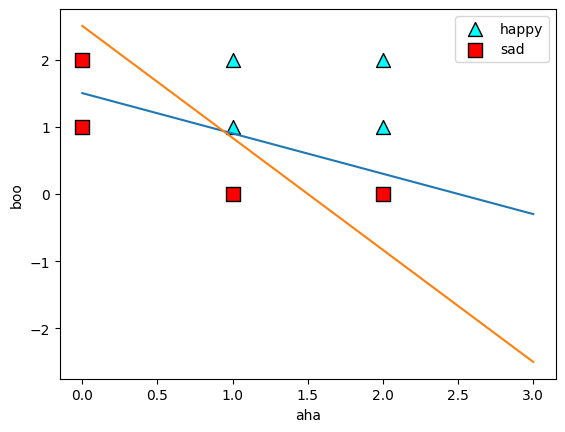

In [5]:
plot_points(X, y, point_size=100)
draw_line(6,10,-15)
draw_line(10,6,-15)

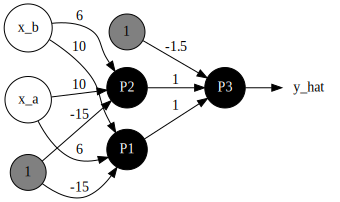

In [6]:
# the neuro-net
g = graphviz.Digraph(format='svg', graph_attr={'rankdir': 'LR'})
g.node('xa', 'x_a', shape='circle')
g.node('xb', 'x_b', shape='circle')
g.node('b1', '1', shape='circle', style='filled', fillcolor='grey')
g.node('b2', '1', shape='circle', style='filled', fillcolor='grey')
g.node('p1', 'P1', shape='circle', style='filled', fillcolor='black', fontcolor='white')
g.node('p2', 'P2', shape='circle', style='filled', fillcolor='black', fontcolor='white')
g.node('p3', 'P3', shape='circle', style='filled', fillcolor='black', fontcolor='white')
g.node('output', 'y_hat', shape='none')

g.edge('xa', 'p1', label='6')
g.edge('xa', 'p2', label='10')
g.edge('xb', 'p1', label='10')
g.edge('xb', 'p2', label='6')
g.edge('b1', 'p1', label='-15')
g.edge('b1', 'p2', label='-15')

g.edge('p1', 'p3', label='1')
g.edge('p2', 'p3', label='1')
g.edge('b2', 'p3', label='-1.5')

g.edge('p3', 'output')
g

In [7]:
def step(x):
  if x >= 0:
    return 1
  else:
    return 0

def line_1(a,b):
  return step(6*a + 10*b - 15)

def line_2(a,b):
  return step(10*a + 6*b - 15)

def bias(a,b):
  return 1

def nn_with_step(a,b):
  return step(step(6*a + 10*b - 15) + step(10*a + 6*b - 15) - 1.5)

def sigmoid(x):
  return np.exp(x)/(1.0 + np.exp(x))

def nn_with_sigmoid(a,b):
  return sigmoid(1.0*sigmoid(6*a + 10*b - 15) + 1.0*sigmoid(10*a + 6*b - 15) - 1.5)

def plot_function(f, ax=None):
  plot_points(X, y, 100, ax)

  def h(x,y): # height function of the contour
    return f(x,y)>=0.5
  xx, yy = np.meshgrid(np.arange(-0.5,3,0.005),
                       np.arange(-0.5,3,0.005))
  Z = np.array([h(i[0], i[1]) for i in np.c_[xx.ravel(), yy.ravel()]])
  Z = Z.reshape(xx.shape)
  if ax is None:
    plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.25, levels=range(-1,2))
    plt.contour(xx, yy, Z,colors = 'k',linewidths = 3)
  else:
    ax.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.25, levels=range(-1,2))
    ax.contour(xx, yy, Z,colors = 'k',linewidths = 3)


## Boundaries of NN 1st layer
1st layer of the neuro-net

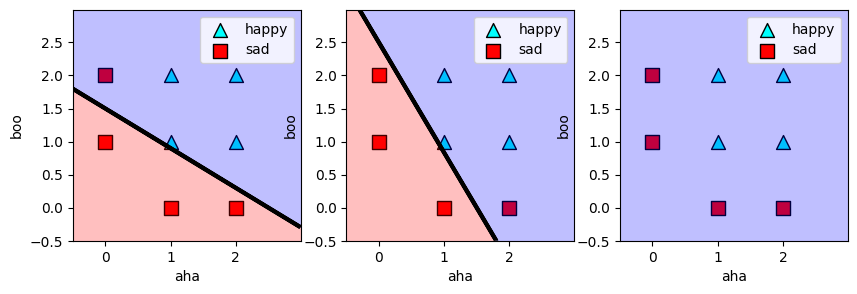

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
plot_function(line_1, ax1)
plot_function(line_2, ax2)
plot_function(bias, ax3)

## Boundaries of NN 2nd layer

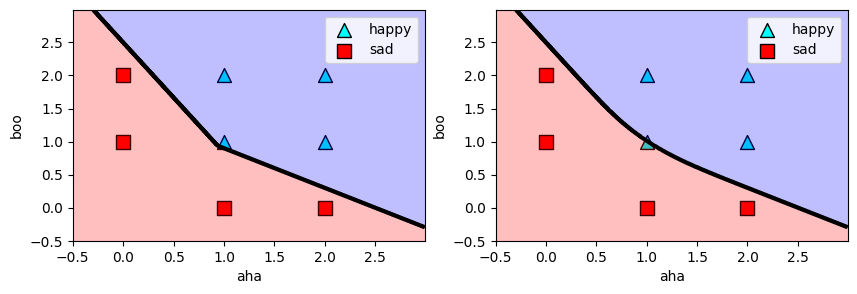

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3))
plot_function(nn_with_step, ax1)
plot_function(nn_with_sigmoid, ax2)

# One-Circle Example

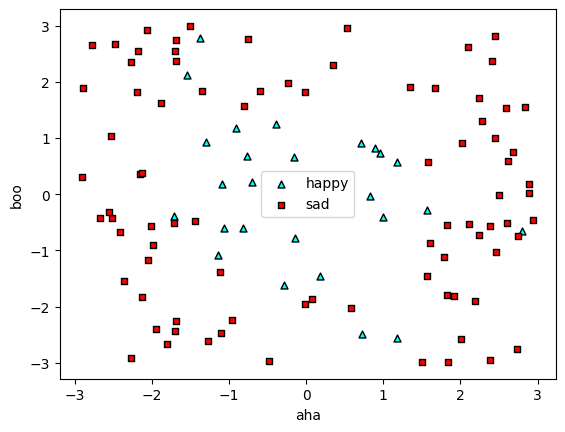

In [10]:
df = pd.read_csv('data/one_circle.csv', index_col=0)
X = np.array(df[['x_1', 'x_2']])
y = np.array(df['y']).astype(int)
plot_points(X,y)

In [11]:
X.shape, y.shape

((110, 2), (110,))

## Tensorflow
Implement the example using Tensorflow

In [12]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical

# turn y (0 or 1) into one-hot, i.e. [0,1] and [1,0]
categorised_y = np.array(to_categorical(y, 2))

# dimensions of the nero-net
# input: (2,), hidden layer 1 (128,), hidden 2 (64,), output (2,)
# activation fn: hidden layers: ReLU, output layer: Softmax
# dropout in hidden layers, ratio 0.2
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(2,)))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', # multi-value version of log loss
              optimizer='adam',
              metrics=['accuracy'])

# train the model
model.fit(X, categorised_y, epochs=100, batch_size=10)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6154 - loss: 0.6892
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7770 - loss: 0.4836  
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7807 - loss: 0.4498 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7821 - loss: 0.4209 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7401 - loss: 0.5190 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7718 - loss: 0.4024 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7887 - loss: 0.4176 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7605 - loss: 0.4256 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7569 - loss: 0.4305 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7519 - loss: 0.4494 
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7326 - loss: 0.4557 
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,312 (102.79 KB)

 Trainable params: 8,770 (34.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,542 (68.53 KB)

In [14]:
categorised_y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


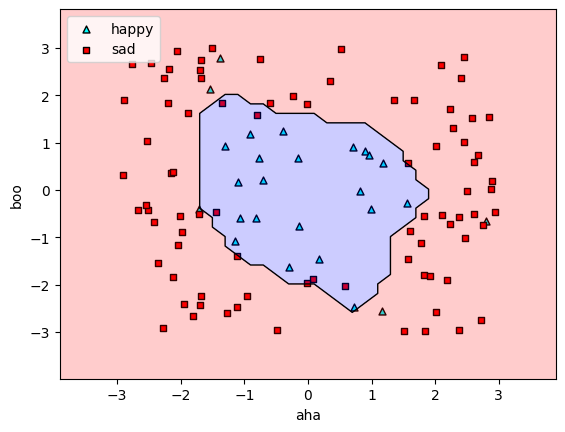

In [23]:
plot_keras_model(X, y, model)

In [17]:
model.predict(np.array([[-1,-3]])), model.predict(np.array([[0,0]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


(array([[0.9986313 , 0.00136872]], dtype=float32),
 array([[0.03045757, 0.96954244]], dtype=float32))

## PyTorch

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

class OneCircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(2, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 2)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = F.softmax(x, dim=1)
    return x

# prepare data
batch_size=10
categorised_y = F.one_hot(torch.tensor(y), 2).float()
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32),
                        categorised_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# create model
model2 = OneCircleModel()
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model2.parameters(), lr=0.001)
num_epochs = 100
for epoch in range(num_epochs):
  model2.train()

  for features, labels in dataloader:
    outputs = model2(features)
    loss = criterion(outputs, labels)

    # back prop
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  print(f"Epoch [{epoch}/{num_epochs}], loss: {loss.item():.4f}")


Epoch [0/100], loss: 0.6040
Epoch [1/100], loss: 0.7472
Epoch [2/100], loss: 0.4788
Epoch [3/100], loss: 0.4413
Epoch [4/100], loss: 0.5933
Epoch [5/100], loss: 0.4191
Epoch [6/100], loss: 0.7956
Epoch [7/100], loss: 0.4856
Epoch [8/100], loss: 0.3485
Epoch [9/100], loss: 0.4639
Epoch [10/100], loss: 0.5279
Epoch [11/100], loss: 0.5127
Epoch [12/100], loss: 0.4169
Epoch [13/100], loss: 0.4185
Epoch [14/100], loss: 0.6962
Epoch [15/100], loss: 0.6048
Epoch [16/100], loss: 0.4802
Epoch [17/100], loss: 0.3746
Epoch [18/100], loss: 0.3313
Epoch [19/100], loss: 0.3783
Epoch [20/100], loss: 0.5547
Epoch [21/100], loss: 0.4251
Epoch [22/100], loss: 0.6402
Epoch [23/100], loss: 0.5907
Epoch [24/100], loss: 0.4778
Epoch [25/100], loss: 0.5446
Epoch [26/100], loss: 0.3462
Epoch [27/100], loss: 0.4719
Epoch [28/100], loss: 0.3939
Epoch [29/100], loss: 0.5637
Epoch [30/100], loss: 0.3345
Epoch [31/100], loss: 0.3671
Epoch [32/100], loss: 0.3576
Epoch [33/100], loss: 0.4379
Epoch [34/100], loss: 0.

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


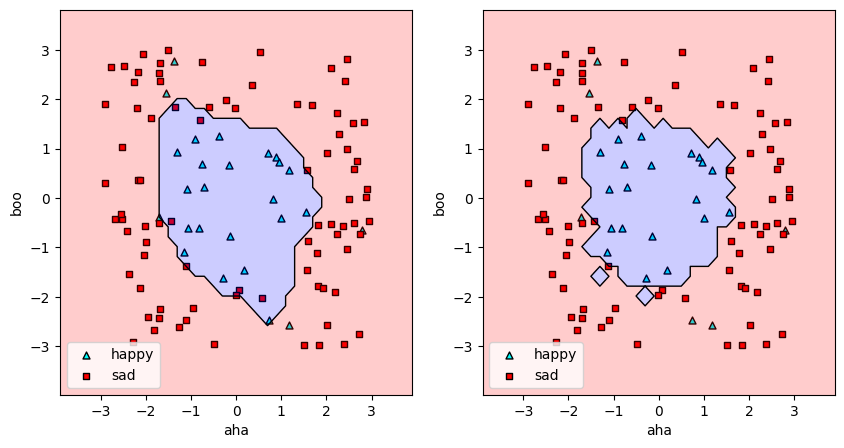

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
plot_keras_model(X, y, model, ax1)
plot_torch_model(X, y, model2, ax2)

In [27]:
model(torch.tensor([[-1.0, -3.0]])), model(torch.tensor([[0.0, 0.0]]))

(<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.9986313 , 0.00136872]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.03045757, 0.96954244]], dtype=float32)>)

In [47]:
with torch.no_grad():
  out1 = model2(torch.tensor([[-1.0, -3.0]]))
  out2 = model2(torch.tensor([[0.0, 0.0]]))
out1, out2

(tensor([[1.0000e+00, 2.6773e-06]]), tensor([[0.0017, 0.9983]]))

# House price example

In [48]:
df = pd.read_csv('data/Hyderabad.csv')
df

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,6968000,1340,Nizampet,2,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
1,29000000,3498,Hitech City,4,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,6590000,1318,Manikonda,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5739000,1295,Alwal,3,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5679000,1145,Kukatpally,2,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,11000000,1460,Nacharam,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2514,26000000,1314,Manikonda,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2515,13300000,2625,Madhapur,3,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2516,10800000,2050,Hitech City,3,0,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


In [49]:
df['Location'].nunique()

243

In [54]:
# turn the location strings into numbers

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
label_encoder = LabelEncoder()
df['Loc'] = label_encoder.fit_transform(df['Location'])
scaler = MinMaxScaler()
df['Area_scaled'] = scaler.fit_transform(df[['Area']])
df['Loc_scaled'] = scaler.fit_transform(df[['Loc']])
df

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,Loc,Area_scaled,Loc_scaled
0,6968000,1340,Nizampet,2,0,0,1,1,1,1,...,0,0,0,0,0,0,0,162,0.094382,0.669421
1,29000000,3498,Hitech City,4,0,0,1,1,1,1,...,0,0,0,0,0,0,0,85,0.336854,0.351240
2,6590000,1318,Manikonda,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,132,0.091910,0.545455
3,5739000,1295,Alwal,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,9,0.089326,0.037190
4,5679000,1145,Kukatpally,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,118,0.072472,0.487603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,11000000,1460,Nacharam,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,150,0.107865,0.619835
2514,26000000,1314,Manikonda,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,132,0.091461,0.545455
2515,13300000,2625,Madhapur,3,1,9,9,9,9,9,...,9,9,9,9,9,9,9,124,0.238764,0.512397
2516,10800000,2050,Hitech City,3,0,9,9,9,9,9,...,9,9,9,9,9,9,9,85,0.174157,0.351240


In [60]:
features = df.drop(['Location', 'Price', 'Area', 'Loc'], axis=1)
labels = df['Price']
features

,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,RainWaterHarvesting,IndoorGames,ShoppingMall,...,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,Area_scaled,Loc_scaled
0,2,0,0,1,1,1,1,1,1,0,...,1,0,0,0,0,0,0,0,0.094382,0.669421
1,4,0,0,1,1,1,1,1,1,0,...,1,0,0,0,0,0,0,0,0.336854,0.351240
2,2,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0.091910,0.545455
3,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.089326,0.037190
4,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.072472,0.487603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2,1,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,0.107865,0.619835
2514,2,1,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,0.091461,0.545455
2515,3,1,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,0.238764,0.512397
2516,3,0,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,0.174157,0.351240


In [64]:
from sklearn.model_selection import train_test_split
# Split the DataFrame into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2014, 39), (504, 39), (2014,), (504,))

## in Tensorflow

In [68]:
# Building the model
model = Sequential()
model.add(Dense(features.shape[1], activation='relu', input_shape=(features.shape[1],)))
model.add(Dropout(.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(1))

# Compiling the model. The metrics flag is added for the model to report the root mean squared error at each epoch.
model.compile(loss = 'mean_squared_error', optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 39)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 39)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,001 (58.60 KB)

 Trainable params: 15,001 (58.60 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
model.fit(features, labels, epochs=30, batch_size=10)

Epoch 1/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 31676335915008.0000 - root_mean_squared_error: 5540046.0000
Epoch 2/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14255588900864.0000 - root_mean_squared_error: 3708262.2500
Epoch 3/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 33556671758336.0000 - root_mean_squared_error: 5675724.0000
Epoch 4/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 24454820265984.0000 - root_mean_squared_error: 4880626.0000
Epoch 5/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 45242241777664.0000 - root_mean_squared_error: 6396304.0000
Epoch 6/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 23896250122240.0000 - root_mean_squared_error: 4856661.0000
Epoch 7/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 30792252129280.0000 - root_mean_squared_error: 5484890.5000
Epoch 8/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21933626228736.0000 - root_mean_squared_error: 4642950.5000
Epoch 9/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 

In [82]:
model.evaluate(features, labels)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8659057246208.0000 - root_mean_squared_error: 2877563.7500


[20754722717696.0, 4555735.0]

In [83]:
preds = model.predict(features)
preds

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[ 7276790.5],
       [27588440. ],
       [ 5705722. ],
       ...,
       [ 9414390. ],
       [ 8794826. ],
       [ 8610796. ]], dtype=float32)

In [85]:
(preds.flatten() - labels)/labels

,Price
0,0.044316
1,-0.048674
2,-0.134185
3,0.473707
4,0.099974
...,...
2513,-0.258778
2514,-0.692229
2515,-0.292151
2516,-0.185664
